In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [2]:
# Load the dataset
#dataset = torchvision.datasets.MNIST(root="", train=True, download=True, transform=torchvision.transforms.ToTensor())
dataset = torchvision.datasets.FashionMNIST(root="", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 2, 2, 9, 2, 1, 8, 7])


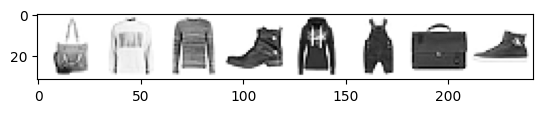

In [3]:
# Peek inside the dataset
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [4]:
################################
## Neuralnetwork Architecture ##
################################
# Adapted from https://huggingface.co/learn/diffusion-course/en/unit1/3

class BasicUNet(nn.Module):
    """A minimal UNet implementation with timestep conditioning."""
    def __init__(self, in_channels=1, out_channels=1, t_channels=16):
        super().__init__()
        # Time step embedding
        self.t_embedding = nn.Sequential(
            nn.Linear(1, t_channels),
            nn.SiLU(),
            nn.Linear(t_channels, t_channels)
        )
        # Down layers
        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels + t_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32 + t_channels, 64, kernel_size=5, padding=2),
            nn.Conv2d(64 + t_channels, 64, kernel_size=5, padding=2),
        ])
        # Up Layers
        self.up_layers = nn.ModuleList([
            nn.Conv2d(64 + t_channels, 64, kernel_size=5, padding=2),
            nn.Conv2d(64 + t_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32 + t_channels, 32, kernel_size=5, padding=2),
        ])
        # Final layer to map to noise
        self.final_layer = nn.Conv2d(32 + t_channels, out_channels, kernel_size=1)
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2) # downscale by a factor of 2
        self.upscale = nn.Upsample(scale_factor=2) # upscale by a factor of 2

    def forward(self, x, t):
        # Embed and reshape t to match batch size
        t_emb = self.t_embedding(t.view(-1, 1)).view(x.size(0), -1, 1, 1)

        skips = [] # Memory for skip connections

        # Down path
        for i, layer in enumerate(self.down_layers):
            x = torch.cat([x, t_emb.expand(x.size(0), t_emb.size(1), x.size(2), x.size(3))], dim=1)
            x = self.act(layer(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                skips.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale spatial dimensions by a factor of 2

        # Up path
        for i, layer in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale spatial dimensions by a factor of 2
                x += skips.pop()  # Add output from skip connection
            x = torch.cat([x, t_emb.expand(x.size(0), t_emb.size(1), x.size(2), x.size(3))], dim=1)
            x = self.act(layer(x))  # Through the layer and the activation function

        # Apply final linear layer without activation function to map to noise
        x = torch.cat([x, t_emb.expand(x.size(0), t_emb.size(1), x.size(2), x.size(3))], dim=1)
        x = self.final_layer(x)

        return x

In [5]:
###########################
## Diffusion Model Class ##
###########################
# Adapted from https://github.com/acids-ircam/creative_ml

class tinyDDPM(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, t_channels=16, n_steps=100):
        super().__init__()
        # UNet
        self.UNet = BasicUNet(in_channels=in_channels, out_channels=out_channels, t_channels=t_channels)
        # Number of diffusion steps
        self.n_steps = n_steps
        # Beta schedule from the paper and coefficients derived from the schedule
        self.betas = torch.linspace(1e-4, 0.02, n_steps) # Linear schedule
        self.alphas = 1-self.betas
        self.alpha_bars = torch.cumprod(self.alphas, 0)
        self.alpha_bars_sqrt = torch.sqrt(self.alpha_bars)
        self.one_minus_alpha_bars_sqrt = torch.sqrt(1 - self.alpha_bars)

    def forward(self, x, t):
        return self.UNet(x,t)

    # Gathers values of input at indeces t (diffusion time steps t) and reshapes them so that they can be broadcasted to the shape of x
    # Used to get the correct alpha bar values
    def get_coefficients(self, input, t, x):
        shape = x.shape
        out = torch.gather(input, 0, t.to(input.device))
        reshape = [t.shape[0]] + [1] * (len(shape) - 1)
        return out.reshape(*reshape)

    # Samples from the forward difussion process: Returns x_t-1 given x_t and t
    def next_sample(self, x, t):
        t = torch.tensor([t]).to(device)
        # Factor to the model output
        eps_factor = ((1 - self.get_coefficients(self.alphas, t, x)) / self.get_coefficients(self.one_minus_alpha_bars_sqrt, t, x)).to(device)
        # Model output
        eps_theta = self.forward(x, t.float())
        # Final values
        mean = (1 / self.get_coefficients(self.alphas, t, x).sqrt()).to(device) * (x - (eps_factor * eps_theta))
        # Sample form a uniform normal
        z = torch.randn_like(x).to(device)
        # Fixed sigma
        sigma_t = self.get_coefficients(self.betas, t, x).sqrt().to(device)
        # Generate next sample
        sample = mean + sigma_t * z
        return (sample)

    # Returns samples from the whole diffusion process starting from pure gaussian noise
    # Shape is the shape of the data the model was trained on
    def get_sample_seq(self, shape):
        current_sample = torch.randn(shape).to(device) # Start with pure noise
        sample_seq = [current_sample]
        # Walk backwards through the difussion process starting at t = T and predict samples with increasingly less noise
        for i in reversed(range(self.n_steps)):
            current_sample = self.next_sample(current_sample, i)
            sample_seq.append(current_sample)
        return sample_seq

    # Noise estimation loss
    def noise_estimation_loss(self, x_0):
        # Noise
        epsilon = torch.randn_like(x_0).to(device)
        # get random timesteps t for each datapoint in the x_0 batch
        t = torch.randint(0, self.n_steps, (x_0.size(0),)).to(device)
        # Get coefficients
        sqrt_a = self.get_coefficients(self.alpha_bars_sqrt, t, x_0).to(device)
        sqrt_1ma = self.get_coefficients(self.one_minus_alpha_bars_sqrt, t, x_0).to(device)
        # Get model prediction
        out = self.forward(sqrt_a*x_0 + sqrt_1ma*epsilon, t.float())
        # Calculate Loss
        loss = (epsilon - out).square().mean()
        return loss



In [6]:
# Exponential moving average class to stabilize training (Taken from https://github.com/acids-ircam/creative_ml)
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

In [8]:
# Load or create new network
model = tinyDDPM()
if os.path.isfile('tinyDDPM_fashion.pt'):
    model.load_state_dict(torch.load('tinyDDPM_fashion.pt', map_location=torch.device(device)))
    print("Model loaded.")
model.to(device)

# Print number of trainable parameters
print(f"Number of trainable parameters: {sum([p.numel() for p in model.parameters()])}")

Model loaded.
Number of trainable parameters: 449441


In [8]:
###################
## Training Loop ##
###################

# Dataloader
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Number of epochs
n_epochs = 200

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Create EMA model
ema = EMA(0.9)
ema.register(model)

for epoch in range(n_epochs):
    for x, _ in train_dataloader:
        # Put data on the device
        x = x.float().to(device)
        
        # Compute the loss.
        loss = model.noise_estimation_loss(x)
        
        # Optimization step
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.) # Perform gradient clipping to stabilize training
        optimizer.step()
        
        # Update the exponential moving average
        ema.update(model)

    # Print loss
    if epoch%10 == 0:
      print(f"Loss at epoch {epoch}: {loss}")

Loss at epoch 0: 0.26716750860214233


In [9]:
# Save the trained model
torch.save(model.state_dict(), 'tinyDDPM_fashion2.pt')

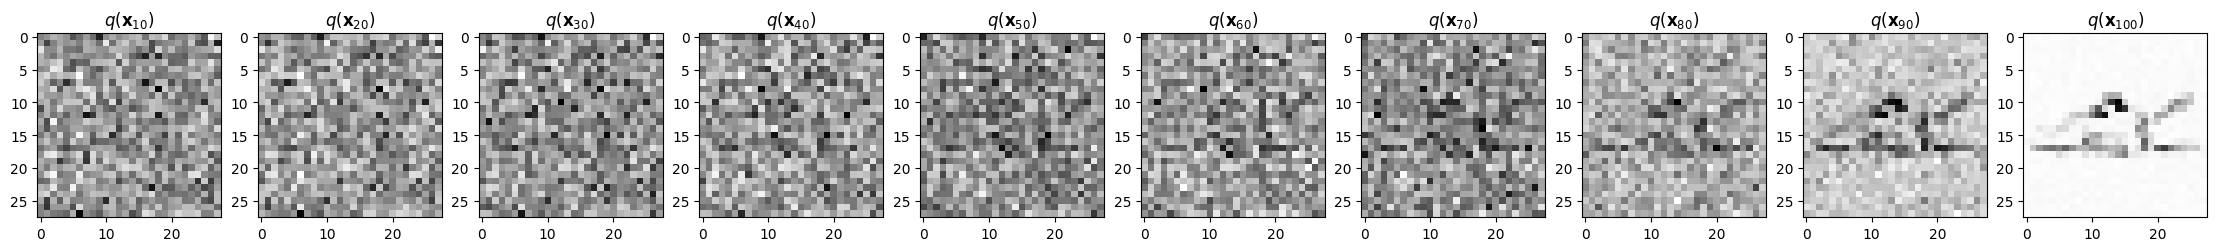

In [15]:
###################
## Visualization ##
###################

# Load a single training sample to get its shape
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
x, _ = next(iter(train_dataloader))
# get sequence of the whole diffusion process for a single sample
sample_seq = model.get_sample_seq(x.shape)
# visualize the difussion process for one sample
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_sample = sample_seq[i * 10].detach().cpu()
    axs[i-1].imshow(torchvision.utils.make_grid(cur_sample)[0], cmap='Greys')
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')
fig.savefig('diffusion_process2.png')

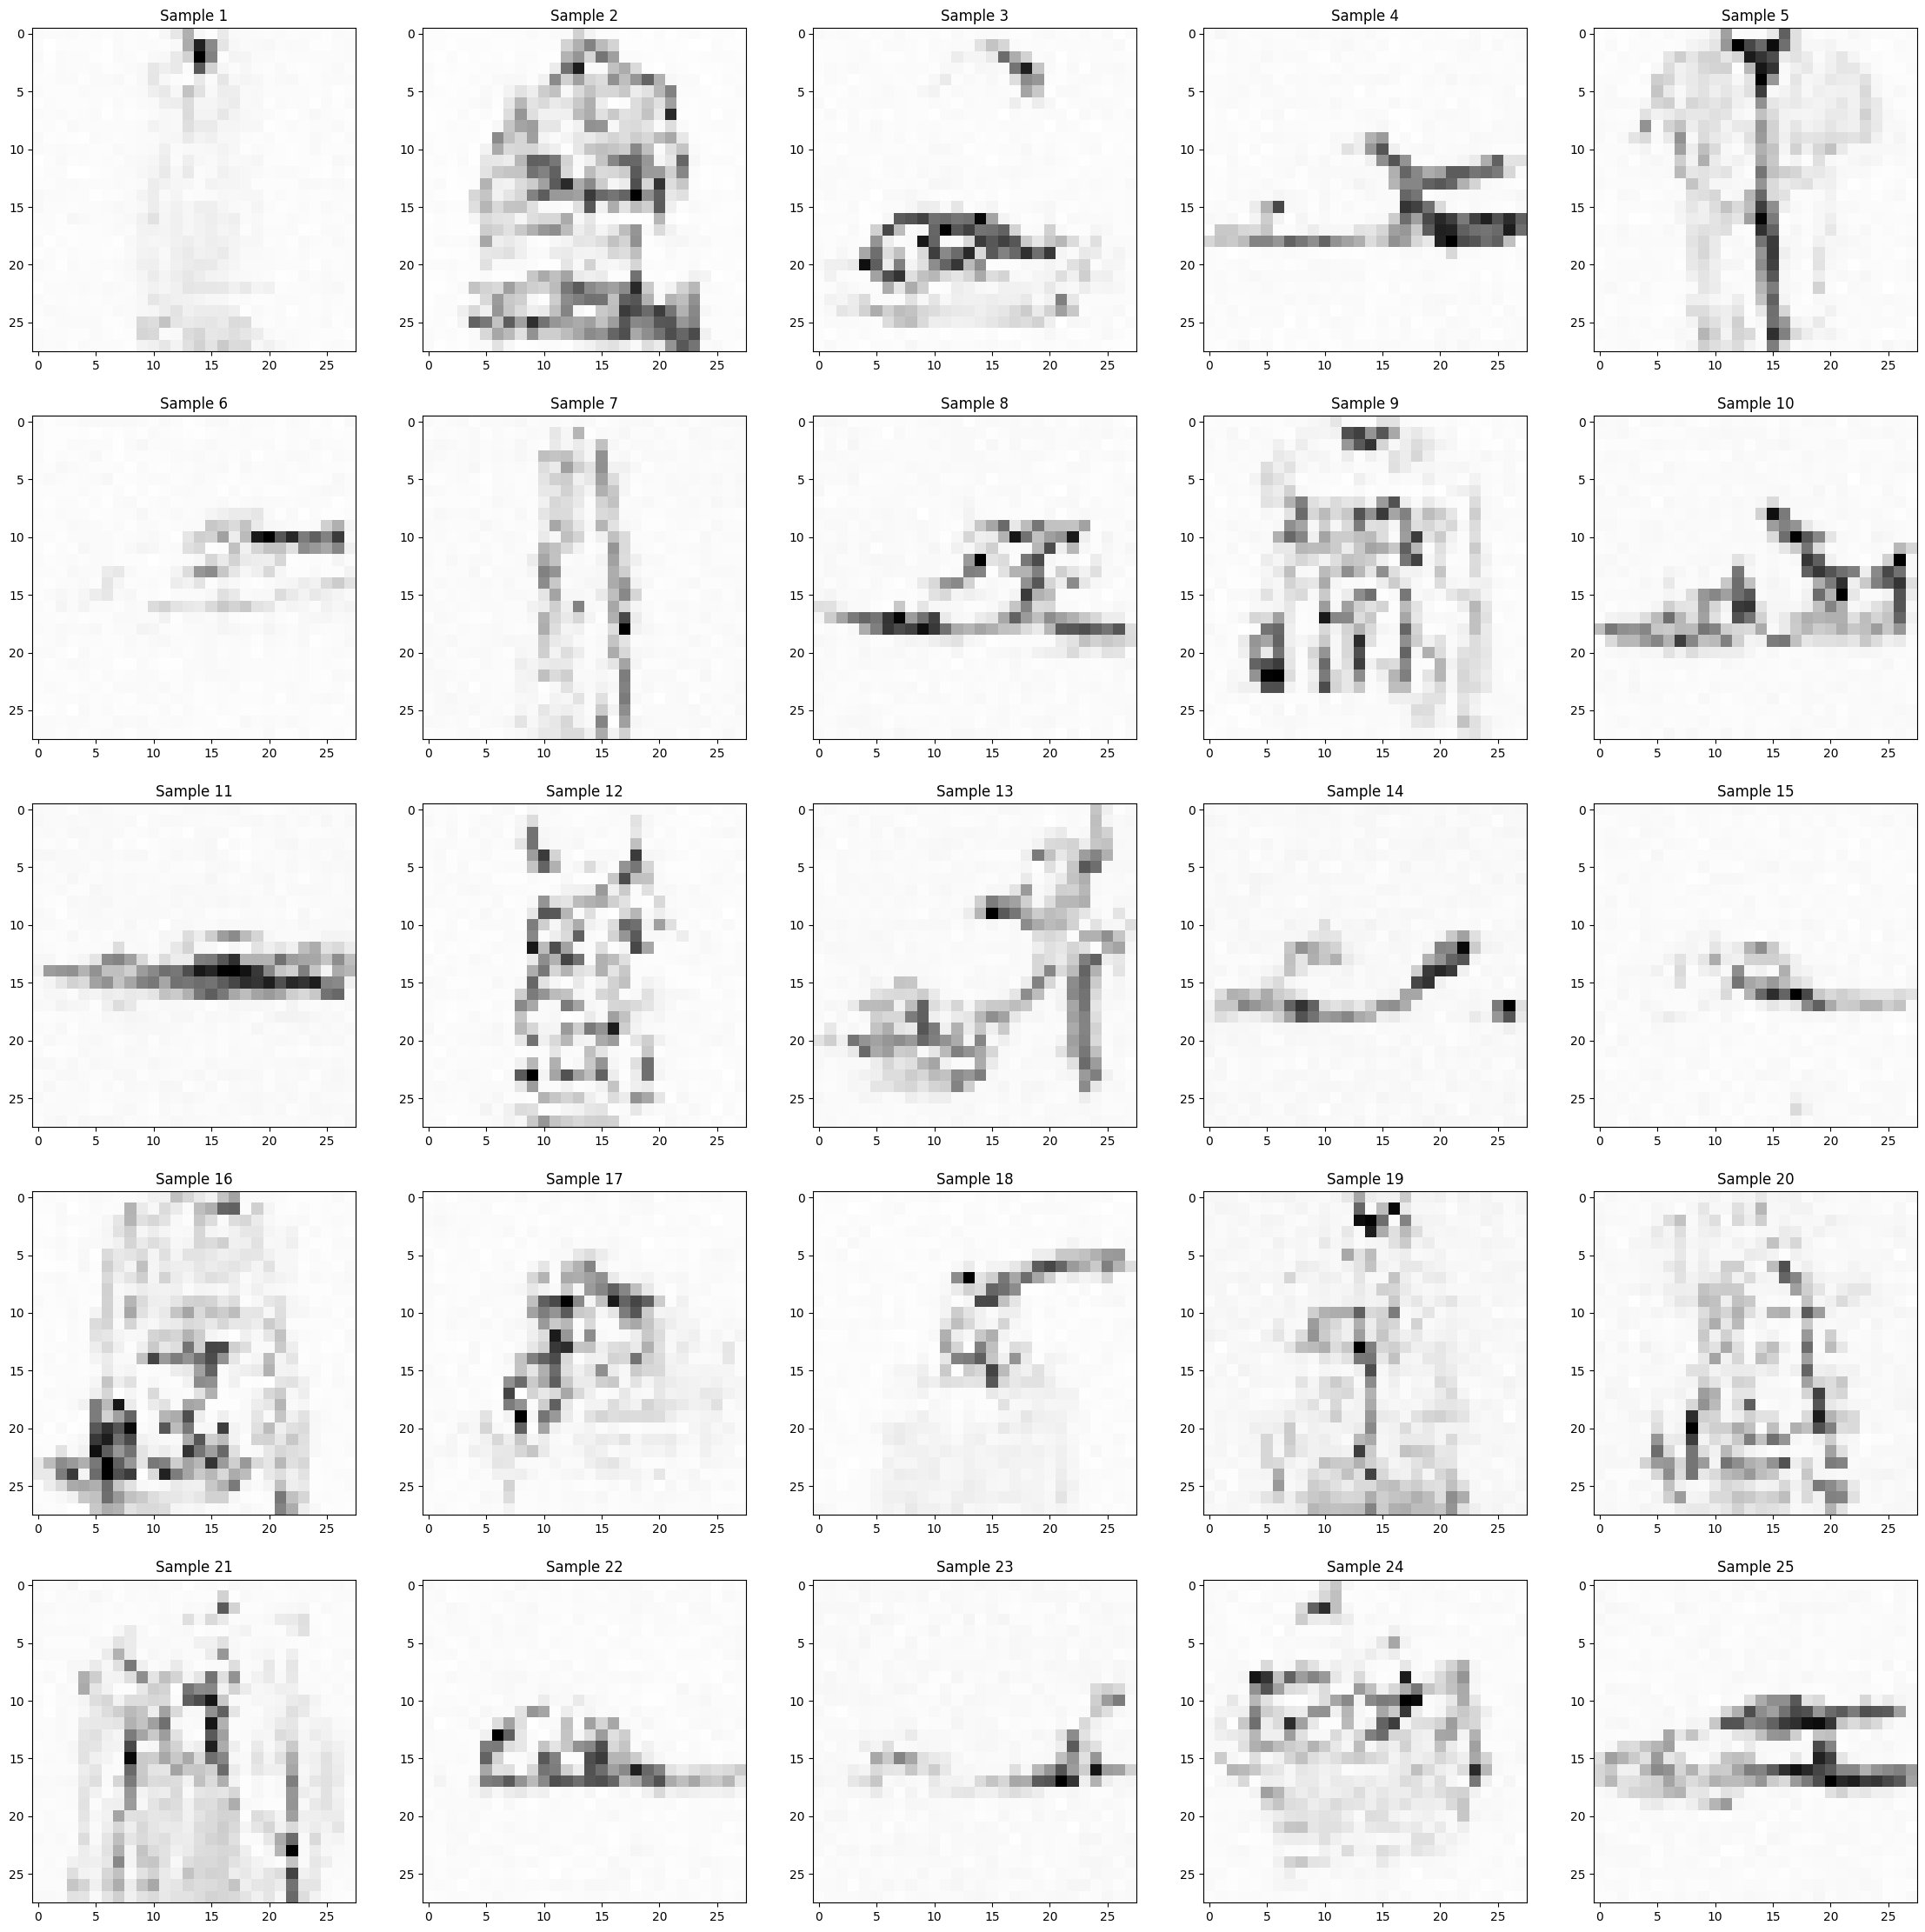

In [10]:
# Generate 25 samples with the trained model
samples = []
for i in range(25):
  sample_seq = model.get_sample_seq(x.shape) # generate a denoising sequence from the model
  samples.append(sample_seq[-1].detach().cpu()) # only use the fully denoised sample (last step)
# Plot the 25 generated samples
fig, axs = plt.subplots(5, 5, figsize=(28, 28))
for i in range(25):
    sample = samples[i]
    axs[i//5][i%5].imshow(torchvision.utils.make_grid(sample)[0], cmap='Greys')
    axs[i//5][i%5].set_title('Sample '+str(i+1))
fig.savefig('generated_samples2.png')